In [1]:
%matplotlib notebook

In [27]:
import numpy as np
import eqcatalog
import hazard.rshalib as rshalib

Read catalog, decluster, and apply completeness

In [3]:
cat = eqcatalog.read_named_catalog('rob').subselect(end_date=2019)

SELECT id_earth, DATE_FORMAT(date, "%Y-%m-%d") as date, TIME_FORMAT(time, "%H:%i:%s") as time, longitude, latitude, depth, ML, MS, MW, MWH, IF(MWH, MWH, IF(MW, MW, IF(MS, MS, ML))) as M, intensity_max, macro_radius, errh, errz, errt, errM, name, type FROM earthquakes WHERE is_true = 1 AND type = "ke" AND longitude BETWEEN 0.000000 and 8.000000 AND latitude BETWEEN 49.000000 and 52.000000 AND TIMESTAMP(date, time) BETWEEN "1350-01-01T00:00:00" and "2020-06-29T14:40:08" ORDER BY date asc, time asc


In [4]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()
dc_window = eqcatalog.declustering.GardnerKnopoff1974Window()
Mrelation = cat.default_Mrelations['MW']
dc_result = dc_method.analyze_clusters(cat, dc_window, Mrelation)
dc_cat = dc_result.get_declustered_catalog()

Better remove these first.


In [5]:
completeness = cat.default_completeness
cc_cat = dc_cat.subselect_completeness(completeness, Mtype='MW', Mrelation=Mrelation)

Number of events constrained by completeness criteria: 380 out of 1562


Construct smoothed seismicity grids:
- one with nth_neighbour=0
- one with nth_neighbour=3
- one with a magnitude-dependent bandwidth (in this case: declustering distance window function)

In [19]:
grid_outline = (1, 7, 49, 52)
grid_spacing = '10km'
bandwidth = 15
min_mag = completeness.min_mag
ss0 = rshalib.source.SmoothedSeismicity(grid_outline, grid_spacing, cc_cat, completeness, Mtype='MW',
                                      Mrelation=Mrelation, min_mag=min_mag, bandwidth=bandwidth,
                                      nth_neighbour=0)
ss3 = rshalib.source.SmoothedSeismicity(grid_outline, grid_spacing, cc_cat, completeness, Mtype='MW',
                                      Mrelation=Mrelation, min_mag=min_mag, bandwidth=bandwidth,
                                      nth_neighbour=3)
ss_md = rshalib.source.SmoothedSeismicity(grid_outline, grid_spacing, cc_cat, completeness, Mtype='MW',
                                          Mrelation=Mrelation, min_mag=min_mag,
                                          bandwidth=dc_window.get_dist_window)

Number of events constrained by completeness criteria: 380 out of 380
Number of events constrained by completeness criteria: 380 out of 380
Number of events constrained by completeness criteria: 380 out of 380


Check total number of earthquakes represented by grid

In [35]:
for ss in (ss0, ss3, ss_md):
    print('%.1f' % np.sum(ss.calc_total_eq_densities(min_mag=min_mag)))
print(len(cc_cat.subselect(region=grid_outline)))

296.9
293.3
295.6
294


Compare earthquake densities for minimum magnitude = minimum completeness magnitude

<IPython.core.display.Javascript object>


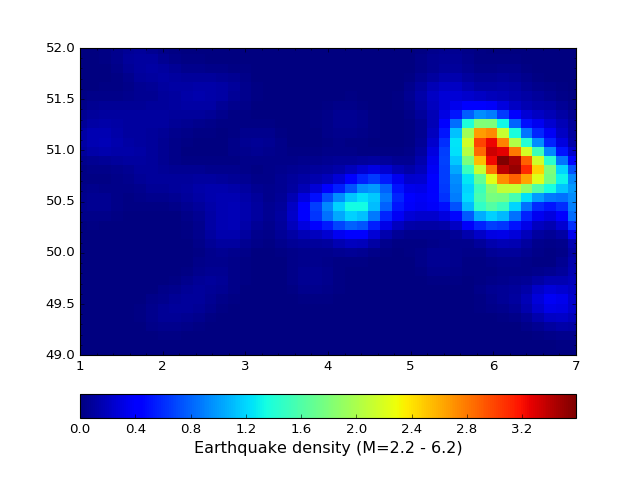

Transforming center to edge coordinates!


In [35]:
ss0.plot_grid('density', min_mag=min_mag)

<IPython.core.display.Javascript object>


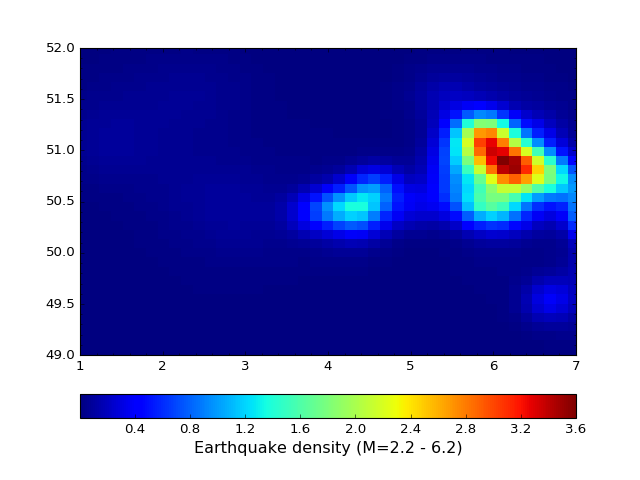

Transforming center to edge coordinates!


In [36]:
ss3.plot_grid('density', min_mag=min_mag)

<IPython.core.display.Javascript object>


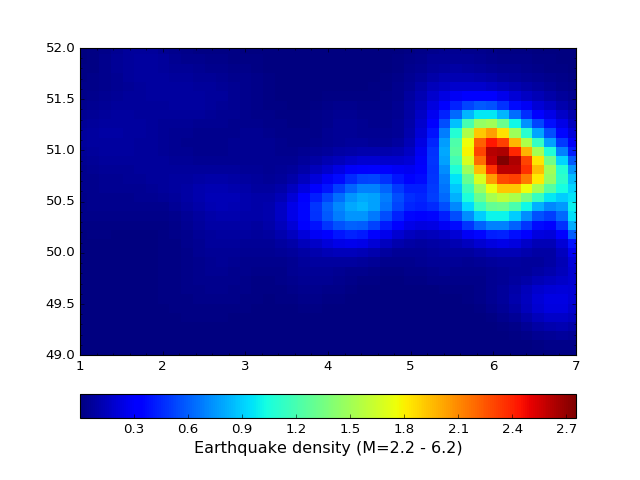

Transforming center to edge coordinates!


In [20]:
ss_md.plot_grid('density', min_mag=min_mag)

Compare earthquake densities for minimum magnitude = 5.0

<IPython.core.display.Javascript object>


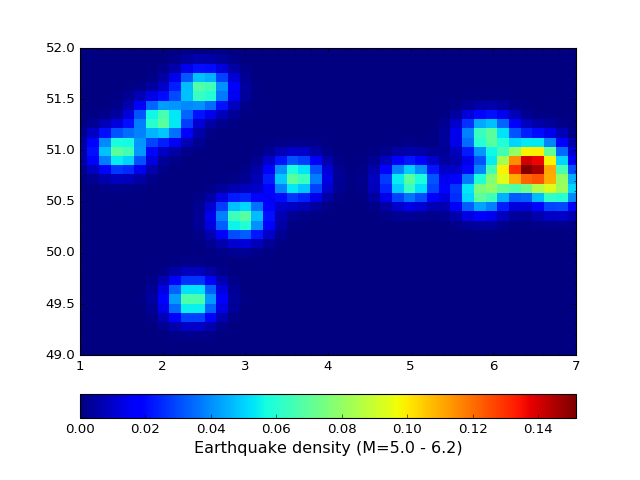

Transforming center to edge coordinates!


In [37]:
ss0.plot_grid('density', min_mag=5.0)

<IPython.core.display.Javascript object>


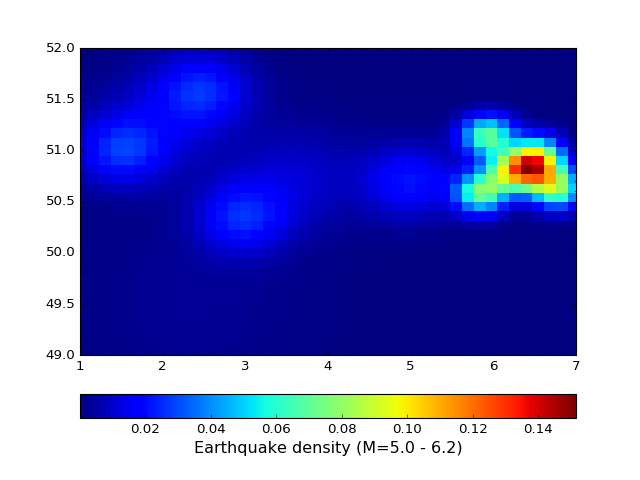

Transforming center to edge coordinates!


In [38]:
ss3.plot_grid('density', min_mag=5.0)

<IPython.core.display.Javascript object>


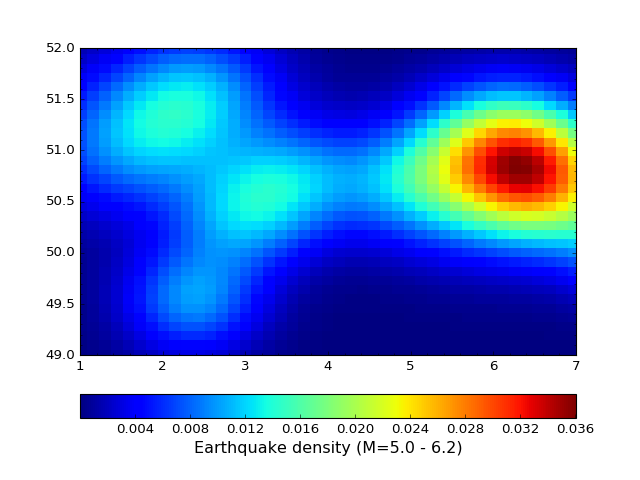

Transforming center to edge coordinates!


In [21]:
ss_md.plot_grid('density', min_mag=5.0)

Compare moment densities

<IPython.core.display.Javascript object>


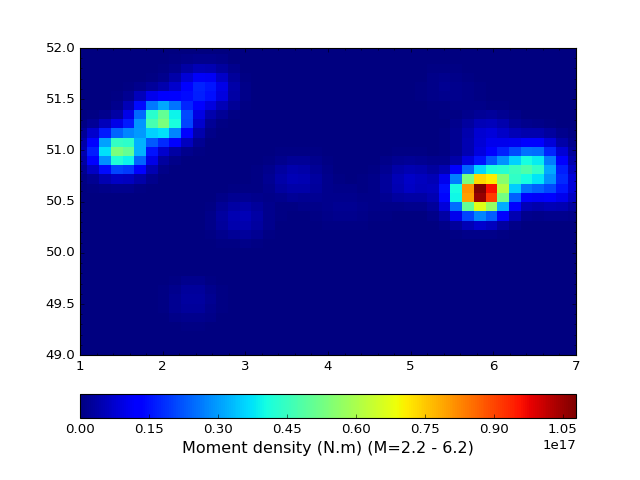

Transforming center to edge coordinates!


In [39]:
ss0.plot_grid('moment_density', min_mag=min_mag)

<IPython.core.display.Javascript object>


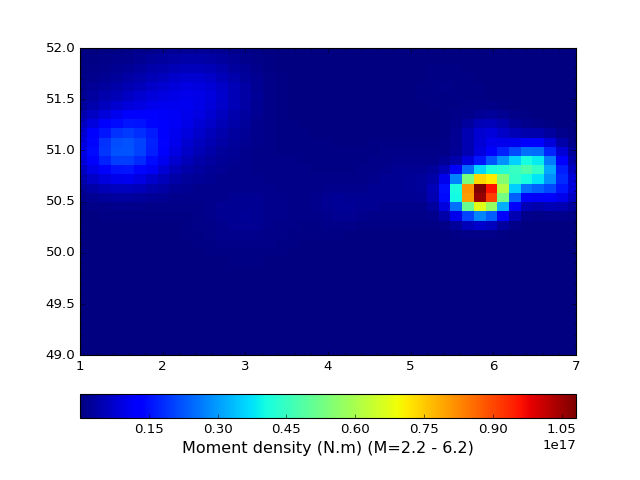

Transforming center to edge coordinates!


In [40]:
ss3.plot_grid('moment_density', min_mag=min_mag)

<IPython.core.display.Javascript object>


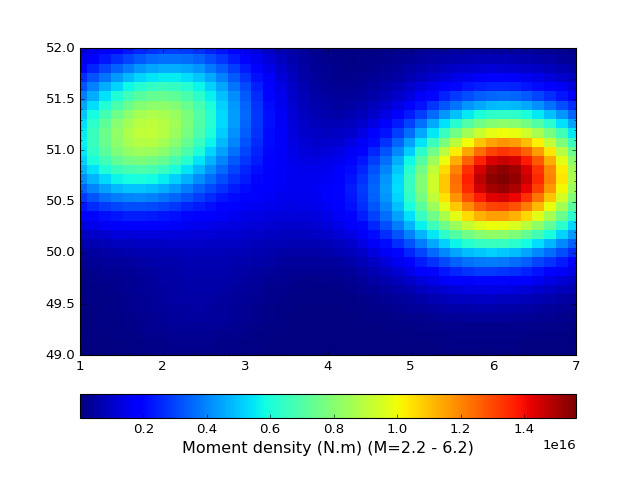

Transforming center to edge coordinates!


In [22]:
ss_md.plot_grid('moment_density', min_mag=min_mag)

Compute MFDs and compare with catalog

In [7]:
Mmax = 7.1
dM = 0.1

In [8]:
cat_imfd = cc_cat.get_incremental_mfd(min_mag, Mmax, dM=dM, Mrelation=Mrelation)
cat_tmfd = cc_cat.get_estimated_mfd(min_mag, Mmax, dM=dM, Mrelation=Mrelation)

Number of events constrained by completeness criteria: 380 out of 380
Maximum-likelihood estimation (Weichert)
BETA=2.166 +/- 0.070; B=0.941 +/- 0.030
Total number of events: 380
LOG(annual rate above M0): 3.076
Annual rate above M5: 0.024 +/- 0.001
Annual rate above M0: 1191.276 +/- 61.111


In [11]:
imfds0 = ss0.calc_incremental_mfds(end_date=2019, min_mag=min_mag, max_mag=Mmax)
tmfds0 = ss0.calc_gr_mfds(cat_tmfd.b_val, end_date=2019, min_mag=min_mag, max_mag=Mmax)

In [12]:
summed_imfd = rshalib.mfd.sum_mfds(imfds0)
summed_tmfd = rshalib.mfd.sum_mfds(tmfds0)

<IPython.core.display.Javascript object>


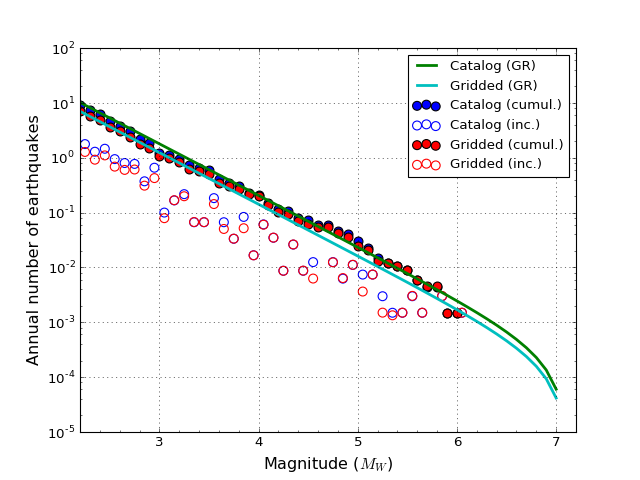

In [11]:
mfd_list = [cat_imfd, cat_tmfd, summed_imfd, summed_tmfd]
labels = ['Catalog', 'Catalog (GR)', 'Gridded', 'Gridded (GR)']
rshalib.mfd.plot_mfds(mfd_list, labels=labels)

In [23]:
imfds3 = ss3.calc_incremental_mfds(end_date=2019, min_mag=min_mag, max_mag=Mmax)
imfds_md = ss_md.calc_incremental_mfds(end_date=2019, min_mag=min_mag, max_mag=Mmax)

<IPython.core.display.Javascript object>


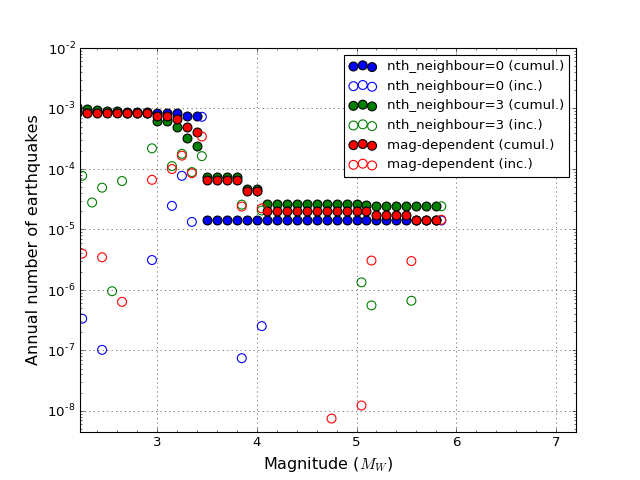

In [24]:
#lon, lat = 5.75, 50.6
#lon, lat = 1.5, 51.
lon, lat = 2., 51.
idx = ss0.get_lonlat_index(lon, lat)
imfd0 = imfds0[idx]
imfd3 = imfds3[idx]
imfd_md = imfds_md[idx]
rshalib.mfd.plot_mfds([imfd0, imfd3, imfd_md], labels=['nth_neighbour=0', 'nth_neighbour=3',
                                                      'mag-dependent'])

Demonstrate plotting of map with folium

In [93]:
map = ss0.get_folium_map('a_value', min_mag=4.0, b_value=cat_tmfd.b_val)

In [94]:
map

In [124]:
import numpy as np
lon, lat = 4., 50.
lon_idx = np.argmin(np.abs(ss0.grid.lons[0] - lon))
lat_idx = np.argmin(np.abs(ss0.grid.lats[:,0] - lat))
print(lon_idx, lat_idx)
#print(ss0.grid.lons[lat_idx, lon_idx])
print(ss0.grid.shape)
print(ss0.grid.lons[11,21])
print(ss0.grid.lats[11,21])
i = np.ravel_multi_index((11,21), ss0.grid.shape)
print(i)
print(ss0.grid_lons[i], ss0.grid_lats[i])

(21, 11)
(34L, 43L)
4.0
50.00450450450448
494
(4.0, 50.00450450450448)


In [116]:
ss0.grid.lats[:,0]

array([49.01351351, 49.1036036 , 49.19369369, 49.28378378, 49.37387387,
       49.46396396, 49.55405405, 49.64414414, 49.73423423, 49.82432432,
       49.91441441, 50.0045045 , 50.09459459, 50.18468468, 50.27477477,
       50.36486486, 50.45495495, 50.54504505, 50.63513514, 50.72522523,
       50.81531532, 50.90540541, 50.9954955 , 51.08558559, 51.17567568,
       51.26576577, 51.35585586, 51.44594595, 51.53603604, 51.62612613,
       51.71621622, 51.80630631, 51.8963964 , 51.98648649])